<h1 style="text-align: center; font-size: 50px;"> 🤖 MLFlow Registration for Multimodal RAG Cacheless
</h1>

# MLFlow Model Service 

In this section, we demonstrate how to deploy a RAG-based chatbot service. This service provides a REST API endpoint that allows users to query the knowledge base with natural language questions, upload new documents to the knowledge base, and manage conversation history, all with built-in safeguards against sensitive information and toxicity. This service encapsulates all the functionality we developed in this notebook, including the document retrieval system, RAG-based question answering capabilities, and MLFlow integration for observation and evaluation. It demonstrates how to use our ChatbotService from the src/service directory. 

## Step 0: Imports and Environment Setup

In [1]:
import time
import os 
from pathlib import Path
import sys
import logging

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Create logger
logger = logging.getLogger("multimodal_rag_logger")
logger.setLevel(logging.INFO)
if not logger.handlers:
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S")
    stream_handler = logging.StreamHandler(sys.stdout)
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)
logger.propagate = False

In [2]:
start_time = time.time()  

logger.info("Notebook execution started.")

2025-08-04 22:34:17 - INFO - Notebook execution started.


In [3]:
%pip install -r ../requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
# === Standard Library Imports ===
import gc
import json
import base64
import tempfile
import threading
import shutil
import warnings
from rank_bm25 import BM25Okapi
from typing import Any, Dict, List, Optional, TypedDict
from collections import defaultdict
from IPython.display import display, Image, Markdown

# === Third-Party Library Imports ===
import mlflow
import pandas as pd
import torch
from langchain.schema.document import Document
from langchain.vectorstores import Chroma
import chromadb
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from mlflow.models.signature import ModelSignature
from mlflow.tracking import MlflowClient
from mlflow.types import ColSpec, DataType, Schema
from PIL import Image as PILImage
from sentence_transformers import SentenceTransformer
from transformers import AutoImageProcessor, AutoTokenizer, SiglipModel, SiglipProcessor
from vllm import LLM, SamplingParams

# === Project-Specific Imports ===
# Add the project root to the system path to allow importing from 'src'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.components import SiglipEmbeddings
from src.wiki_pages_clone import orchestrate_wiki_clone
from src.local_genai_judge import LocalGenAIJudge
from src.utils import (
    configure_hf_cache,
    multimodal_rag_asset_status,
    load_config,
    load_secrets,
    load_mm_docs_clean,
)

2025-08-04 22:34:24.472435: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 22:34:24.494378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754346864.505609     875 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754346864.508840     875 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754346864.520627     875 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

INFO 08-04 22:34:26 [__init__.py:244] Automatically detected platform cuda.


In [5]:
warnings.filterwarnings("ignore")
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["VLLM_WORKER_MULTIPROC_METHOD"] = "spawn"

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

logger.info(f"Using device: {device}")

2025-08-04 22:34:27 - INFO - Using device: cuda


## Step 1: Configurations

### Verify Assets

In [ ]:
CONFIG_PATH = "../configs/config.yaml"
SECRETS_PATH = "../configs/secrets.yaml"

LOCAL_MODEL = "/home/jovyan/datafabric/Qwen2.5-VL-7B-Instruct-GPTQ-Int4"
CONTEXT_DIR: Path = Path("../data/context")
CHROMA_DIR: Path = Path("../data/chroma_store")     
CACHE_DIR: Path = CHROMA_DIR / "semantic_cache"
MANIFEST_PATH: Path = CHROMA_DIR / "manifest.json"

IMAGE_DIR = CONTEXT_DIR / "images"
WIKI_METADATA_DIR = CONTEXT_DIR / "wiki_flat_structure.json"

CHROMA_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

multimodal_rag_asset_status(
    local_model_path=LOCAL_MODEL,
    config_path=CONFIG_PATH,
    secrets_path=SECRETS_PATH,
    wiki_metadata_dir=WIKI_METADATA_DIR,
    context_dir=CONTEXT_DIR,
    chroma_dir=CHROMA_DIR,
    cache_dir=CACHE_DIR,
    manifest_path=MANIFEST_PATH
)

2025-08-04 22:34:27 - INFO - Local Model is properly configured. 
2025-08-04 22:34:27 - INFO - Config is properly configured. 
2025-08-04 22:34:27 - INFO - Secrets is properly configured. 
2025-08-04 22:34:27 - INFO - wiki_flat_structure.json is properly configured. 
2025-08-04 22:34:27 - INFO - CONTEXT is properly configured. 
2025-08-04 22:34:27 - INFO - CHROMA is properly configured. 
2025-08-04 22:34:27 - INFO - CACHE is properly configured. 
2025-08-04 22:34:27 - INFO - MANIFEST is properly configured. 


In [8]:
config = load_config(CONFIG_PATH)

### Config HuggingFace Caches

In the next cell, we configure HuggingFace cache, so that all the models downloaded from them are persisted locally, even after the workspace is closed. This is a future desired feature for AI Studio and the GenAI addon.

In [9]:
configure_hf_cache()

In [10]:
# Initialize HuggingFace Embeddings
txt_embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/e5-large-v2",
    cache_folder="/tmp/hf_cache"
)

### MLflow Configuration

In [11]:
MODEL_NAME = "AIStudio-Multimodal-Chatbot-Model"
RUN_NAME = f"Register_{MODEL_NAME}"
EXPERIMENT_NAME = "AIStudio-Multimodal-Chatbot-Experiment"

# Set MLflow tracking URI and experiment
# This should be configured for your environment, e.g., a remote server or local file path
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "/phoenix/mlflow"))
mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

logger.info(f"Using MLflow tracking URI: {mlflow.get_tracking_uri()}")
logger.info(f"Using MLflow experiment: '{EXPERIMENT_NAME}'")

2025-08-04 22:34:30 - INFO - Using MLflow tracking URI: /phoenix/mlflow
2025-08-04 22:34:30 - INFO - Using MLflow experiment: 'AIStudio-Multimodal-Chatbot-Experiment'


## Step 2: MLflow Model Setup

In [12]:
class MultimodalRagModel(mlflow.pyfunc.PythonModel):
    """
    An MLflow PythonModel for a stateless, in-memory Multimodal RAG pipeline.
    This model uses Qwen-VL via vLLM for generation.
    """

    # ==========================================================================
    # 1. Inner Class for the RAG Generation Pipeline
    # ==========================================================================
    class QwenVLMM:
        """Minimal, self-contained multimodal QA wrapper."""
        def __init__(self, llm: LLM, tok: AutoTokenizer, image_processor: AutoImageProcessor, device: str, text_db: Chroma, image_db: Chroma, bm25_index: Optional[BM25Okapi], doc_map: dict):
            self.llm = llm
            self.tok = tok
            self.image_processor = image_processor
            self.device = device
            self.text_db = text_db
            self.image_db = image_db
            self.bm25_index = bm25_index
            self.doc_map = doc_map
        
        @staticmethod
        def _reciprocal_rank_fusion(results: list[list[Document]], k: int = 60) -> list[tuple[Document, float]]:
            """Performs Reciprocal Rank Fusion on multiple ranked lists of documents."""
            ranked_lists = [ {doc.page_content: (doc, i + 1) for i, doc in enumerate(res)} for res in results]
            rrf_scores = defaultdict(float)
            all_docs = {}
            for ranked_list in ranked_lists:
                for content, (doc, rank) in ranked_list.items():
                    rrf_scores[content] += 1 / (k + rank)
                    if content not in all_docs: all_docs[content] = doc
            fused_results = [(all_docs[content], rrf_scores[content]) for content in sorted(rrf_scores, key=rrf_scores.get, reverse=True)]
            return fused_results

        def _retrieve_mm(self, query: str, k_text: int = 3, k_img: int = 2, recall_k: int = 20) -> dict[str, any]:
            """Retrieves relevant documents and images based on the query using both dense and sparse retrieval methods."""
            dense_hits = self.text_db.similarity_search(query, k=recall_k)
            
            # If no dense hits, try sparse retrieval with BM25
            sparse_hits = []
            if self.bm25_index and list(self.doc_map.keys()):
                tokenized_query = query.lower().split(" ")
                sparse_texts = self.bm25_index.get_top_n(tokenized_query, list(self.doc_map.keys()), n=recall_k)
                sparse_hits = [self.doc_map[text] for text in sparse_texts]

            if not dense_hits and not sparse_hits:
                return {"docs": [], "scores": [], "images": []}

            # Perform Reciprocal Rank Fusion on the hits
            fused_results = self._reciprocal_rank_fusion([dense_hits, sparse_hits])
            
            final_docs = [doc for doc, score in fused_results[:k_text]]
            final_scores = [score for doc, score in fused_results[:k_text]]

            # Retrieve images based on the sources of the final documents
            retrieved_images = []
            if final_docs and self.image_db:
                final_sources = list(set(d.metadata["source"] for d in final_docs))
                image_hits = self.image_db.similarity_search(query, k=k_img, filter={"source": {"$in": final_sources}})
                retrieved_images = [img.page_content for img in image_hits]

            return {"docs": final_docs, "scores": final_scores, "images": retrieved_images}

        def generate(self, query: str, **retrieval_kwargs) -> Dict[str, Any]:
            """Generates a response using the Qwen-VL RAG pipeline."""
            start_gen_time = time.time()
            
            hits = self._retrieve_mm(query, **retrieval_kwargs)
            docs, images = hits["docs"], hits["images"]
            
            if not docs and not images:
                return {"reply": "Based on the provided context, I cannot answer this question.", "used_images": [], "generation_time_seconds": 0.0}

            
            if len(images) > 2:
                logger.warning(f"Limiting images from {len(images)} to 2 to save memory")
                images = images[:2]
                
            context_str = "\n\n".join(
                f"<source_document name=\"{d.metadata.get('source', 'unknown')}\">\n{d.page_content}\n</source_document>"
                for d in docs
            )
            
            system_prompt = """You are a Multimodal RAG Assistant. Your task is to answer the user's query using ONLY the provided context from retrieved documents and images.
            
            **Instructions:**
            1. **Analyze Context:** Carefully examine the retrieved images and text documents provided in the context.
            2. **Answer Directly:** Provide a clear, comprehensive answer to the user's query by synthesizing information from both text and image sources.
            3. **Stay Focused:** Do not include unnecessary sections or verbose explanations. Answer the question directly and concisely.
            4. **No Hallucination:** Use ONLY the information provided in the context. Do not make up facts or add information not present in the retrieved materials.
            
            **Output Format:**
            - If the context is relevant: Provide a direct answer using the retrieved context.
            - If the context is irrelevant: Respond with "The provided context does not contain relevant information to answer the query."
            """
            
            if images:
                # Use the standard Qwen2.5-VL image token format
                image_tokens = ""
                for i in range(len(images)):
                    image_tokens += f"<|vision_start|><|image_pad|><|vision_end|>"
                
                user_content = f"""{image_tokens}
    
                <context>
                {context_str}
                </context>
                
                <user_query>
                {query}
                </user_query>"""
            else:
                user_content = f"""<context>
                {context_str}
                </context>
                
                <user_query>
                {query}
                </user_query>"""

            messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": user_content}]
            prompt_string = self.tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

            try:
                self._clear_cuda()
                sampling_params = SamplingParams(temperature=0.0, top_p=1.0, max_tokens=2048)
                
                # --- ✅ Updated Image Processing Logic ---
                if images:
                    pil_images = []
                    for i, img_path in enumerate(images):
                        try:
                            img = PILImage.open(img_path).convert("RGB")
                            # Resize large images while preserving aspect ratio
                            if img.size[0] > 512 or img.size[1] > 512:
                                img.thumbnail((512, 512), PILImage.Resampling.LANCZOS)
                            pil_images.append(img)
                            logger.info(f"Processed image {i+1}: {img_path} -> new size {img.size}")
                        except Exception as e:
                            logger.warning(f"Failed to process image {img_path}: {e}")
                            continue
                    
                    if not pil_images:
                        logger.warning("No images successfully processed, proceeding text-only")
                        request_payload = {"prompt": prompt_string}
                    else:
                        request_payload = {
                            "prompt": prompt_string,
                            "multi_modal_data": {"image": pil_images},
                        }
                else:
                    request_payload = {"prompt": prompt_string}

                output_list = self.llm.generate(request_payload, sampling_params=sampling_params)
                reply = output_list[0].outputs[0].text.strip() if output_list and output_list[0].outputs else "Error: no output from LLM."
                
                self._clear_cuda()
                end_gen_time = time.time()
                
                if reply == "The provided context does not contain relevant information to answer the query.":
                    images = []
                    
                return {"reply": reply, "used_images": images, "generation_time_seconds": end_gen_time - start_gen_time}

            except RuntimeError as e:
                logger.error("Qwen-VL generation failed: %s", e)
                return {"reply": f"Error during generation: {e}", "used_images": images, "generation_time_seconds": 0.0}

        def _clear_cuda(self):
            """Clears CUDA memory."""
            if torch.cuda.is_available():
                gc.collect()
                torch.cuda.empty_cache()
                torch.cuda.synchronize()

    # ==========================================================================
    # 2. MLflow `pyfunc` Life-cycle and Service Methods
    # ==========================================================================
    def load_context(self, context: mlflow.pyfunc.PythonModelContext) -> None:
        """Initializes the model and loads all necessary components into memory."""
        logger.info("--- Initializing Stateless MultimodalRAG Service (Qwen-VL) ---")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        logger.info("--- Service initialized with a single locked collection. ---")
        model_path = Path(context.artifacts["local_model_dir"]).resolve()
        e5_model_path = context.artifacts["e5_model_dir"]
        siglip_model_path = context.artifacts["siglip_model_dir"]
        
        logger.info("Loading text embedding model (E5)...")
        self.text_embed_model = HuggingFaceEmbeddings(model_name=e5_model_path, model_kwargs={"device": self.device})
        
        logger.info("Loading image embedding model (SigLIP)...")
        self.siglip_embed_model = SiglipEmbeddings(model_id=siglip_model_path, device=self.device)

        logger.info("Loading main LLM (Qwen-VL via vLLM)...")
        base_model_name = "Qwen/Qwen2.5-VL-7B-Instruct"
        self.tok = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
        if self.tok.pad_token is None: self.tok.pad_token = self.tok.eos_token
        self.image_processor = AutoImageProcessor.from_pretrained(base_model_name, trust_remote_code=True, use_fast=True)
        
        if self.device == "cuda":
            self.llm = LLM(
                model=str(model_path),
                quantization="gptq",
                gpu_memory_utilization=0.80,
                max_model_len=4096,
                enforce_eager=True,
                limit_mm_per_prompt={"image": 2},
                disable_custom_all_reduce=True,
                tensor_parallel_size=1,
                dtype="float16",
            )
            logger.info("Initializing LocalGenAIJudge for self-evaluation...")
            self.judge = LocalGenAIJudge(llm=self.llm, tokenizer=self.tok)
        else:
            self.llm = None
            self.judge = None # Judge is None if no CUDA LLM
            logger.error("Qwen-VL with vLLM requires a CUDA device. LLM and Judge not loaded.")
        self.db_lock = threading.Lock()

        self.text_collection_name = "rag_text_collection"
        self.image_collection_name = "rag_image_collection"

        # Use a persistent client that lives with the model
        self.chroma_client = chromadb.Client()
        self.text_vector_store = Chroma(
            client=self.chroma_client,
            collection_name=self.text_collection_name,
            embedding_function=self.text_embed_model,
        )
        self.image_vector_store = Chroma(
            client=self.chroma_client,
            collection_name=self.image_collection_name,
            embedding_function=self.siglip_embed_model,
        )
        
        logger.info("--- Service initialized with all models loaded. Ready for queries. ---")

    def _build_transient_kb(self, config: dict, secrets: dict, temp_path: Path) -> Dict[str, Any]:
        """Fetches, processes, and indexes data entirely in memory from a given temp path."""
        logger.info("Cloning wiki to temporary directory...")
        orchestrate_wiki_clone(pat=secrets['AIS_ADO_TOKEN'], config=config, output_dir=temp_path)
        
        image_dir = temp_path / "images"
        wiki_metadata_path = temp_path / "wiki_flat_structure.json"
        
        if not wiki_metadata_path.exists():
            raise FileNotFoundError("Cloning failed: 'wiki_flat_structure.json' not found.")
        
        all_raw_docs = load_mm_docs_clean(wiki_metadata_path, image_dir)
        all_chunks = self._chunk_docs(all_raw_docs)

        # 1. Wipe the text collection by deleting all existing documents by ID
        existing_text_ids = self.text_vector_store._collection.get(include=[])['ids']
        if existing_text_ids:
            logger.info(f"Wiping {len(existing_text_ids)} documents from text collection.")
            self.text_vector_store._collection.delete(ids=existing_text_ids)

        # 2. Add new documents. LangChain handles the embeddings automatically.
        if all_chunks:
            self.text_vector_store.add_documents(documents=all_chunks)
        logger.info(f"Populated text collection with {len(all_chunks)} chunks.")
    
        # 3. Wipe the image collection
        img_paths, img_ids, img_meta = self._collect_image_vectors(all_raw_docs, image_dir)
        existing_image_ids = self.image_vector_store._collection.get(include=[])['ids']
        if existing_image_ids:
            logger.info(f"Wiping {len(existing_image_ids)} images from image collection.")
            self.image_vector_store._collection.delete(ids=existing_image_ids)

        # 4. Add new images
        if img_paths:
            self.image_vector_store.add_texts(texts=img_paths, metadatas=img_meta, ids=img_ids)
        logger.info(f"Populated image collection with {len(img_paths)} images.")

        # BM25 index is still built in memory per request
        unique_splits = list({doc.page_content: doc for doc in all_chunks}.values())
        corpus = [doc.page_content for doc in unique_splits]
        bm25_index = BM25Okapi([doc.split(" ") for doc in corpus]) if corpus else None
        doc_map = {doc.page_content: doc for doc in unique_splits}
    
        return {
            "text_db": self.text_vector_store, 
            "image_db": self.image_vector_store, 
            "bm25_index": bm25_index, 
            "doc_map": doc_map
        }

    def predict(self, context: mlflow.pyfunc.PythonModelContext, model_input: pd.DataFrame) -> pd.DataFrame:
        """Processes a query using the stateless RAG pipeline."""
        with self.db_lock:
            logger.info("Received new query. Lock acquired. Processing new request...")
            pipeline_start_time = time.time()
            
            query = model_input["query"].iloc[0]
            payload = json.loads(model_input["payload"].iloc[0])
            transient_kb, rag_pipeline = None, None
    
            with tempfile.TemporaryDirectory() as temp_dir:
                try:
                    temp_path = Path(temp_dir)
                    transient_kb = self._build_transient_kb(config=payload["config"], secrets=payload["secrets"], temp_path=temp_path)
                    
                    if not self.llm:
                        raise RuntimeError("LLM not loaded. Cannot proceed with generation.")
                        
                    rag_pipeline = self.QwenVLMM(
                        llm=self.llm, tok=self.tok, image_processor=self.image_processor,
                        device=self.device, **transient_kb
                    )
    
                    response_dict = rag_pipeline.generate(query)
                    
                    logger.info("Performing self-evaluation with LocalGenAIJudge...")
                    # Ensure judge exists before trying to use it
                    if self.judge:
                        context_str = "\n\n".join(d.page_content for d in transient_kb["text_db"].similarity_search(query, k=3))
                        eval_df = pd.DataFrame([{"questions": query, "result": response_dict["reply"], "source_documents": context_str}])
                        
                        response_dict["faithfulness"] = self.judge.evaluate_faithfulness(eval_df).iloc[0]
                        response_dict["relevance"] = self.judge.evaluate_relevance(eval_df).iloc[0]
                    else:
                        response_dict["faithfulness"] = -1.0
                        response_dict["relevance"] = -1.0
                    
                    # Encode images to Base64 for the response
                    base64_images = []
                    for path in response_dict.get("used_images", []):
                        try:
                            with open(path, "rb") as img_file:
                                base64_images.append(base64.b64encode(img_file.read()).decode('utf-8'))
                        except FileNotFoundError:
                            logger.warning(f"Image file not found at temp path: {path}")
                    response_dict["used_images"] = json.dumps(base64_images)
                    
                    pipeline_end_time = time.time()
                    response_dict["total_pipeline_time_seconds"] = pipeline_end_time - pipeline_start_time
    
                    logger.info("Request finished. Releasing lock.")
                    return pd.DataFrame([response_dict])

                except Exception as e:
                    logger.error(f"Stateless RAG pipeline failed while lock was held: {e}", exc_info=True)
                    return pd.DataFrame([{"status": "error", "message": str(e)}])
                
                finally:
                    logger.info("Cleaning up transient KB objects and VRAM...")
                    del transient_kb, rag_pipeline
                    gc.collect()
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                        torch.cuda.synchronize()
                    logger.info("Cleanup complete.")
        
    # ==========================================================================
    # 3. Helper and Class Methods
    # ==========================================================================
    def _chunk_docs(self, docs: List[Document]) -> List[Document]:
        """Takes a list of raw docs and performs chunking with unique IDs per doc."""
        header_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=[("#", "title"), ("##", "section")])
        recursive_splitter = RecursiveCharacterTextSplitter(chunk_size=1200, chunk_overlap=200)
        all_chunks: list[Document] = []
        
        for doc in docs:
            page_title = Path(doc.metadata["source"]).stem.replace("-", " ")
            section_docs = header_splitter.split_text(doc.page_content)
            doc_chunk_counter = 0
            for section in section_docs:
                tiny_texts = recursive_splitter.split_text(section.page_content)
                for tiny in tiny_texts:
                    chunk_metadata = {"title": page_title, "source": doc.metadata["source"], "section_header": section.metadata.get("header", ""),"chunk_id": doc_chunk_counter}
                    all_chunks.append(Document(page_content=f"{page_title}\n\n{tiny.strip()}", metadata=chunk_metadata))
                    doc_chunk_counter += 1
        return all_chunks
        
    def _collect_image_vectors(self, mm_raw_docs: List[Document], image_dir: Path):
        """Scans raw docs and returns paths, IDs, and metadata for unique images."""
        img_paths, img_ids, img_meta = [], [], []
        seen = set()
        for doc in mm_raw_docs:
            src = doc.metadata["source"]
            for name in doc.metadata.get("images", []):
                img_id = f"{src}::{name}"
                if img_id in seen: continue
                seen.add(img_id)
                img_path = image_dir / name
                if img_path.is_file():
                    img_paths.append(str(img_path))
                    img_ids.append(img_id)
                    img_meta.append({"source": src, "image": name})
        return img_paths, img_ids, img_meta

    @classmethod
    def log_model(cls, model_name: str, local_model: str) -> None:
        """Logs the Multimodal RAG model to MLflow with all necessary artifacts."""
        logger.info(f"--- Logging '{model_name}' Service to MLflow ---")
        with tempfile.TemporaryDirectory() as temp_dir:
            temp_path = Path(temp_dir)
            e5_path = temp_path / "e5-large-v2"
            SentenceTransformer("intfloat/e5-large-v2").save(str(e5_path))
            
            siglip_path = temp_path / "siglip2-base-patch16-224"
            SiglipModel.from_pretrained("google/siglip2-base-patch16-224").save_pretrained(siglip_path)
            SiglipProcessor.from_pretrained("google/siglip2-base-patch16-224").save_pretrained(siglip_path)
            
            artifacts = {"local_model_dir": local_model, "e5_model_dir": str(e5_path), "siglip_model_dir": str(siglip_path)}
            
            input_schema = Schema([
                ColSpec(DataType.string, "query"),
                ColSpec(DataType.string, "payload"),
            ])
            # Updated output schema - removed faithfulness and relevance
            output_schema = Schema([
                ColSpec(DataType.string, "reply", required=False),
                ColSpec(DataType.string, "used_images", required=False),
                ColSpec(DataType.double, "total_pipeline_time_seconds", required=False),
                ColSpec(DataType.double, "generation_time_seconds", required=False),
                ColSpec(DataType.double, "faithfulness", required=False),
                ColSpec(DataType.double, "relevance", required=False),
                ColSpec(DataType.string, "status", required=False),
                ColSpec(DataType.string, "message", required=False),
            ])
            
            signature = ModelSignature(inputs=input_schema, outputs=output_schema)

            mlflow.pyfunc.log_model(
                artifact_path=model_name, python_model=cls(), artifacts=artifacts,
                pip_requirements="../requirements.txt", signature=signature, code_paths=["../src"]
            )
        logger.info(f"✅ Successfully logged '{model_name}' service and cleaned up.")


## Step 3: Start Run, Log & Register Model

In [13]:
%%time

# --- Start MLflow Run and Log the Model ---
try:
    with mlflow.start_run(run_name=RUN_NAME) as run:
        run_id = run.info.run_id
        logger.info(f"Started MLflow run: {run_id}")

        # Use the class method to log the model and its artifacts
        MultimodalRagModel.log_model(model_name=MODEL_NAME, local_model=LOCAL_MODEL)

        model_uri = f"runs:/{run_id}/{MODEL_NAME}"
        logger.info(f"Registering model from URI: {model_uri}")
        
        # Register the model in the MLflow Model Registry
        mlflow.register_model(model_uri=model_uri, name=MODEL_NAME)
        logger.info(f"✅ Successfully registered model '{MODEL_NAME}'")

except FileNotFoundError as e:
    logger.error(f"Error: A required file or directory was not found. Please ensure the project structure is correct.")
    logger.error(f"Details: {e}")
except Exception as e:
    logger.error(f"An unexpected error occurred during the MLflow run: {e}", exc_info=True)

2025-08-04 22:34:30 - INFO - Started MLflow run: 443ddaddde304c5cb64ad7ab9e70ef6e
2025-08-04 22:34:30 - INFO - --- Logging 'AIStudio-Multimodal-Chatbot-Model' Service to MLflow ---


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


2025-08-04 22:36:35 - INFO - ✅ Successfully logged 'AIStudio-Multimodal-Chatbot-Model' service and cleaned up.
2025-08-04 22:36:35 - INFO - Registering model from URI: runs:/443ddaddde304c5cb64ad7ab9e70ef6e/AIStudio-Multimodal-Chatbot-Model
2025-08-04 22:36:35 - INFO - ✅ Successfully registered model 'AIStudio-Multimodal-Chatbot-Model'
CPU times: user 3.67 s, sys: 24.3 s, total: 28 s
Wall time: 2min 4s


Registered model 'AIStudio-Multimodal-Chatbot-Model' already exists. Creating a new version of this model...
Created version '2' of model 'AIStudio-Multimodal-Chatbot-Model'.


In [14]:
# --- Retrieve the latest version from the Model Registry ---
try:
    client = MlflowClient()
    versions = client.get_latest_versions(MODEL_NAME, stages=["None"])
    if not versions:
        raise RuntimeError(f"No registered versions found for model '{MODEL_NAME}'.")
    
    latest_version = versions[0]
    logger.info(f"Found latest version '{latest_version.version}' for model '{MODEL_NAME}' in stage '{latest_version.current_stage}'.")
    model_uri_registry = latest_version.source

except Exception as e:
    logger.error(f"Failed to retrieve model from registry: {e}", exc_info=True)
    model_uri_registry = None # Ensure variable exists


2025-08-04 22:36:35 - INFO - Found latest version '2' for model 'AIStudio-Multimodal-Chatbot-Model' in stage 'None'.


In [15]:
%%time

if model_uri_registry:
    try:
        logger.info(f"Loading model from: {model_uri_registry}")
        loaded_model = mlflow.pyfunc.load_model(model_uri=model_uri_registry)
        logger.info("✅ Successfully loaded model from registry.")
    except Exception as e:
        logger.error(f"Failed to load model from registry URI: {e}", exc_info=True)
        loaded_model = None
else:
    logger.warning("Skipping model loading due to previous errors.")
    loaded_model = None

2025-08-04 22:36:35 - INFO - Loading model from: /phoenix/mlflow/594178897322281329/443ddaddde304c5cb64ad7ab9e70ef6e/artifacts/AIStudio-Multimodal-Chatbot-Model
2025-08-04 22:36:35 - INFO - --- Initializing Stateless MultimodalRAG Service (Qwen-VL) ---
2025-08-04 22:36:35 - INFO - --- Service initialized with a single locked collection. ---
2025-08-04 22:36:35 - INFO - Loading text embedding model (E5)...
2025-08-04 22:36:40 - INFO - Loading image embedding model (SigLIP)...
2025-08-04 22:36:46 - INFO - Loading main LLM (Qwen-VL via vLLM)...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

INFO 08-04 22:36:55 [config.py:841] This model supports multiple tasks: {'classify', 'reward', 'generate', 'embed'}. Defaulting to 'generate'.
WARNING 08-04 22:36:55 [config.py:3371] Casting torch.bfloat16 to torch.float16.
INFO 08-04 22:36:55 [config.py:1472] Using max model len 4096
INFO 08-04 22:36:55 [gptq_marlin.py:174] Detected that the model can run with gptq_marlin, however you specified quantization=gptq explicitly, so forcing gptq. Use quantization=gptq_marlin for faster inference
WARNING 08-04 22:36:55 [config.py:960] gptq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 08-04 22:36:56 [config.py:2285] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 08-04 22:36:56 [cuda.py:102] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used


2025-08-04 22:36:58.911642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754347018.920577    1086 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754347018.923160    1086 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754347018.930274    1086 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754347018.930306    1086 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754347018.930308    1086 computation_placer.cc:177] computation placer alr

INFO 08-04 22:37:03 [__init__.py:244] Automatically detected platform cuda.
INFO 08-04 22:37:04 [core.py:526] Waiting for init message from front-end.
INFO 08-04 22:37:04 [core.py:69] Initializing a V1 LLM engine (v0.9.2) with config: model='/phoenix/mlflow/594178897322281329/443ddaddde304c5cb64ad7ab9e70ef6e/artifacts/AIStudio-Multimodal-Chatbot-Model/artifacts/Qwen2.5-VL-7B-Instruct-GPTQ-Int4-1', speculative_config=None, tokenizer='/phoenix/mlflow/594178897322281329/443ddaddde304c5cb64ad7ab9e70ef6e/artifacts/AIStudio-Multimodal-Chatbot-Model/artifacts/Qwen2.5-VL-7B-Instruct-GPTQ-Int4-1', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=True, quantization=gptq, enforce_eager=True, kv_cache_dtype=auto,  device_config=cuda, decoding_confi

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:11<00:11, 11.91s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:22<00:00, 11.02s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:22<00:00, 11.16s/it]



INFO 08-04 22:37:29 [default_loader.py:272] Loading weights took 22.45 seconds
INFO 08-04 22:37:30 [gpu_model_runner.py:1801] Model loading took 6.5934 GiB and 22.962434 seconds
INFO 08-04 22:37:30 [gpu_model_runner.py:2238] Encoder cache will be initialized with a budget of 16384 tokens, and profiled with 1 image items of the maximum feature size.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
/opt/conda/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


INFO 08-04 22:38:12 [gpu_worker.py:232] Available KV cache memory: 0.60 GiB
INFO 08-04 22:38:12 [kv_cache_utils.py:716] GPU KV cache size: 11,280 tokens
INFO 08-04 22:38:12 [kv_cache_utils.py:720] Maximum concurrency for 4,096 tokens per request: 2.75x
INFO 08-04 22:38:12 [core.py:172] init engine (profile, create kv cache, warmup model) took 42.72 seconds
2025-08-04 22:38:13 - INFO - Initializing LocalGenAIJudge for self-evaluation...
2025-08-04 22:38:13 - INFO - --- Service initialized with all models loaded. Ready for queries. ---
2025-08-04 22:38:13 - INFO - ✅ Successfully loaded model from registry.
CPU times: user 3.27 s, sys: 1.56 s, total: 4.83 s
Wall time: 1min 37s


## Step 4: Display Results

In [16]:
def display_results(query: str, result_df: pd.DataFrame):
    """Helper to neatly print the query, reply, and display Base64 images."""
    if result_df.empty:
        print("Received an empty result.")
        return

    # Extract results from the DataFrame
    row = result_df.iloc[0]
    reply = row.get("reply", "No reply generated.")
    # This field now contains a JSON string of a list of Base64 strings
    used_images_json = row.get("used_images", "[]")
    gen_time = row.get("generation_time_seconds", 0)
    total_pipeline_time_seconds = row.get("total_pipeline_time_seconds", 0)
    faithfulness = row.get("faithfulness", 0)
    relevance = row.get("relevance", 0)

    # Safely parse the JSON string of Base64 images
    base64_images = []
    try:
        # Use json.loads to parse the string into a list
        base64_images = json.loads(used_images_json)
    except (json.JSONDecodeError, TypeError):
        print("Warning: Could not parse image data from the API response.")

    # Display the output
    print("---" * 20)
    print(f"❓ Query:\n{query}\n")
    print(f"🤖 Reply:")
    display(Markdown(reply)) # Render markdown for better formatting
    
    print(f"\n📊 Faithfulness: {faithfulness:.4f} | Relevance: {relevance:.4f}")
    print(f"⏱️ Generation Time: {gen_time:.2f}s\n")
    print(f" Total Pipeline Time: {total_pipeline_time_seconds:.2f}s\n")

    if base64_images and isinstance(base64_images, list):
        print(f"🖼️ Displaying {len(base64_images)} retrieved image(s):")
        for b64_string in base64_images:
            try:
                # Decode the Base64 string into bytes
                image_bytes = base64.b64decode(b64_string)
                # Display the image directly from the bytes data
                display(Image(data=image_bytes, width=400))
            except Exception as e:
                print(f"  - Could not decode or display an image: {e}")
    else:
        print("▶ No images were retrieved for this query.")
    print("---" * 20 + "\n")

2025-08-04 22:38:13 - INFO - --- Running sample inference with the loaded model ---
2025-08-04 22:38:13 - INFO - Environment variable not found. Falling back to secrets.yaml.
2025-08-04 22:38:13 - INFO - Processing query: 'What are the AI Blueprints Repository best practices?'...
2025-08-04 22:38:13 - INFO - Received new query. Lock acquired. Processing new request...
2025-08-04 22:38:13 - INFO - Cloning wiki to temporary directory...
2025-08-04 22:38:13 - INFO - Starting ADO Wiki clone process...
2025-08-04 22:38:13 - INFO - Cloning wiki 'Phoenix-DS-Platform.wiki' to temporary directory: /tmp/tmpsps_ufgn
2025-08-04 22:38:38 - INFO - Scanning for Markdown files...
2025-08-04 22:38:38 - INFO - → Found 575 Markdown pages.
2025-08-04 22:38:38 - INFO - Copying referenced images to /tmp/tmpp5cffxbv/images...
2025-08-04 22:38:39 - INFO - → 791 unique images copied.
2025-08-04 22:38:39 - INFO - Assembling flat JSON structure...
2025-08-04 22:38:39 - INFO - ✅ Wiki data successfully cloned to /

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


2025-08-04 22:41:15 - INFO - Processed image 1: /tmp/tmpp5cffxbv/images/image-a188c151-b523-474c-a0cf-09c2988f9e03.png -> new size (512, 284)
2025-08-04 22:41:16 - INFO - Processed image 2: /tmp/tmpp5cffxbv/images/image-ee2b37bf-81f0-44fa-933a-e9f8b2a7dcda.png -> new size (512, 269)


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

2025-08-04 22:41:25 - INFO - Performing self-evaluation with LocalGenAIJudge...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

2025-08-04 22:41:27 - INFO - Request finished. Releasing lock.
2025-08-04 22:41:27 - INFO - Cleaning up transient KB objects and VRAM...
2025-08-04 22:41:27 - INFO - Cleanup complete.
------------------------------------------------------------
❓ Query:
What are the AI Blueprints Repository best practices?

🤖 Reply:


The AI Blueprints Repository best practices include:

1. **Ensuring Reproducibility**: Projects should be reproducible with minimal effort by following their `README.md`.
2. **New Files with Each PR**: Every new pull request for blueprint projects must include:
   - A fully and sequentially executed Jupyter notebook with all cell outputs.
   - Updated PDF files showing successful API interactions via the Swagger, HTML, and Streamlit user interfaces.
3. **Concise and Insightful Comments**: Provide meaningful comments to improve readability and guide users.
4. **Informative Markdown Cells**: Use well-written markdown cells to explain the purpose and content of each section.
5. **Constants Management**: Avoid hardcoded values; define constants for experiment names, paths, and configurations at the top.
6. **Cross-Platform File Paths**: Use the `pathlib` library for defining file paths to ensure OS compatibility.
7. **Two Main Notebooks per Project**: Each blueprint project will include two standardized main notebooks:
   - `run-workflow.ipynb`: Executes the pipeline using custom inputs and configurations.
   - `register-model.ipynb`: Registers trained models to MLflow, generates API logic, and tests the registration.
8. **Other Notebooks for the Project**: Additional notebooks may be included for the project as needed.


📊 Faithfulness: 0.9500 | Relevance: 0.9000
⏱️ Generation Time: 10.78s

 Total Pipeline Time: 193.72s

🖼️ Displaying 2 retrieved image(s):


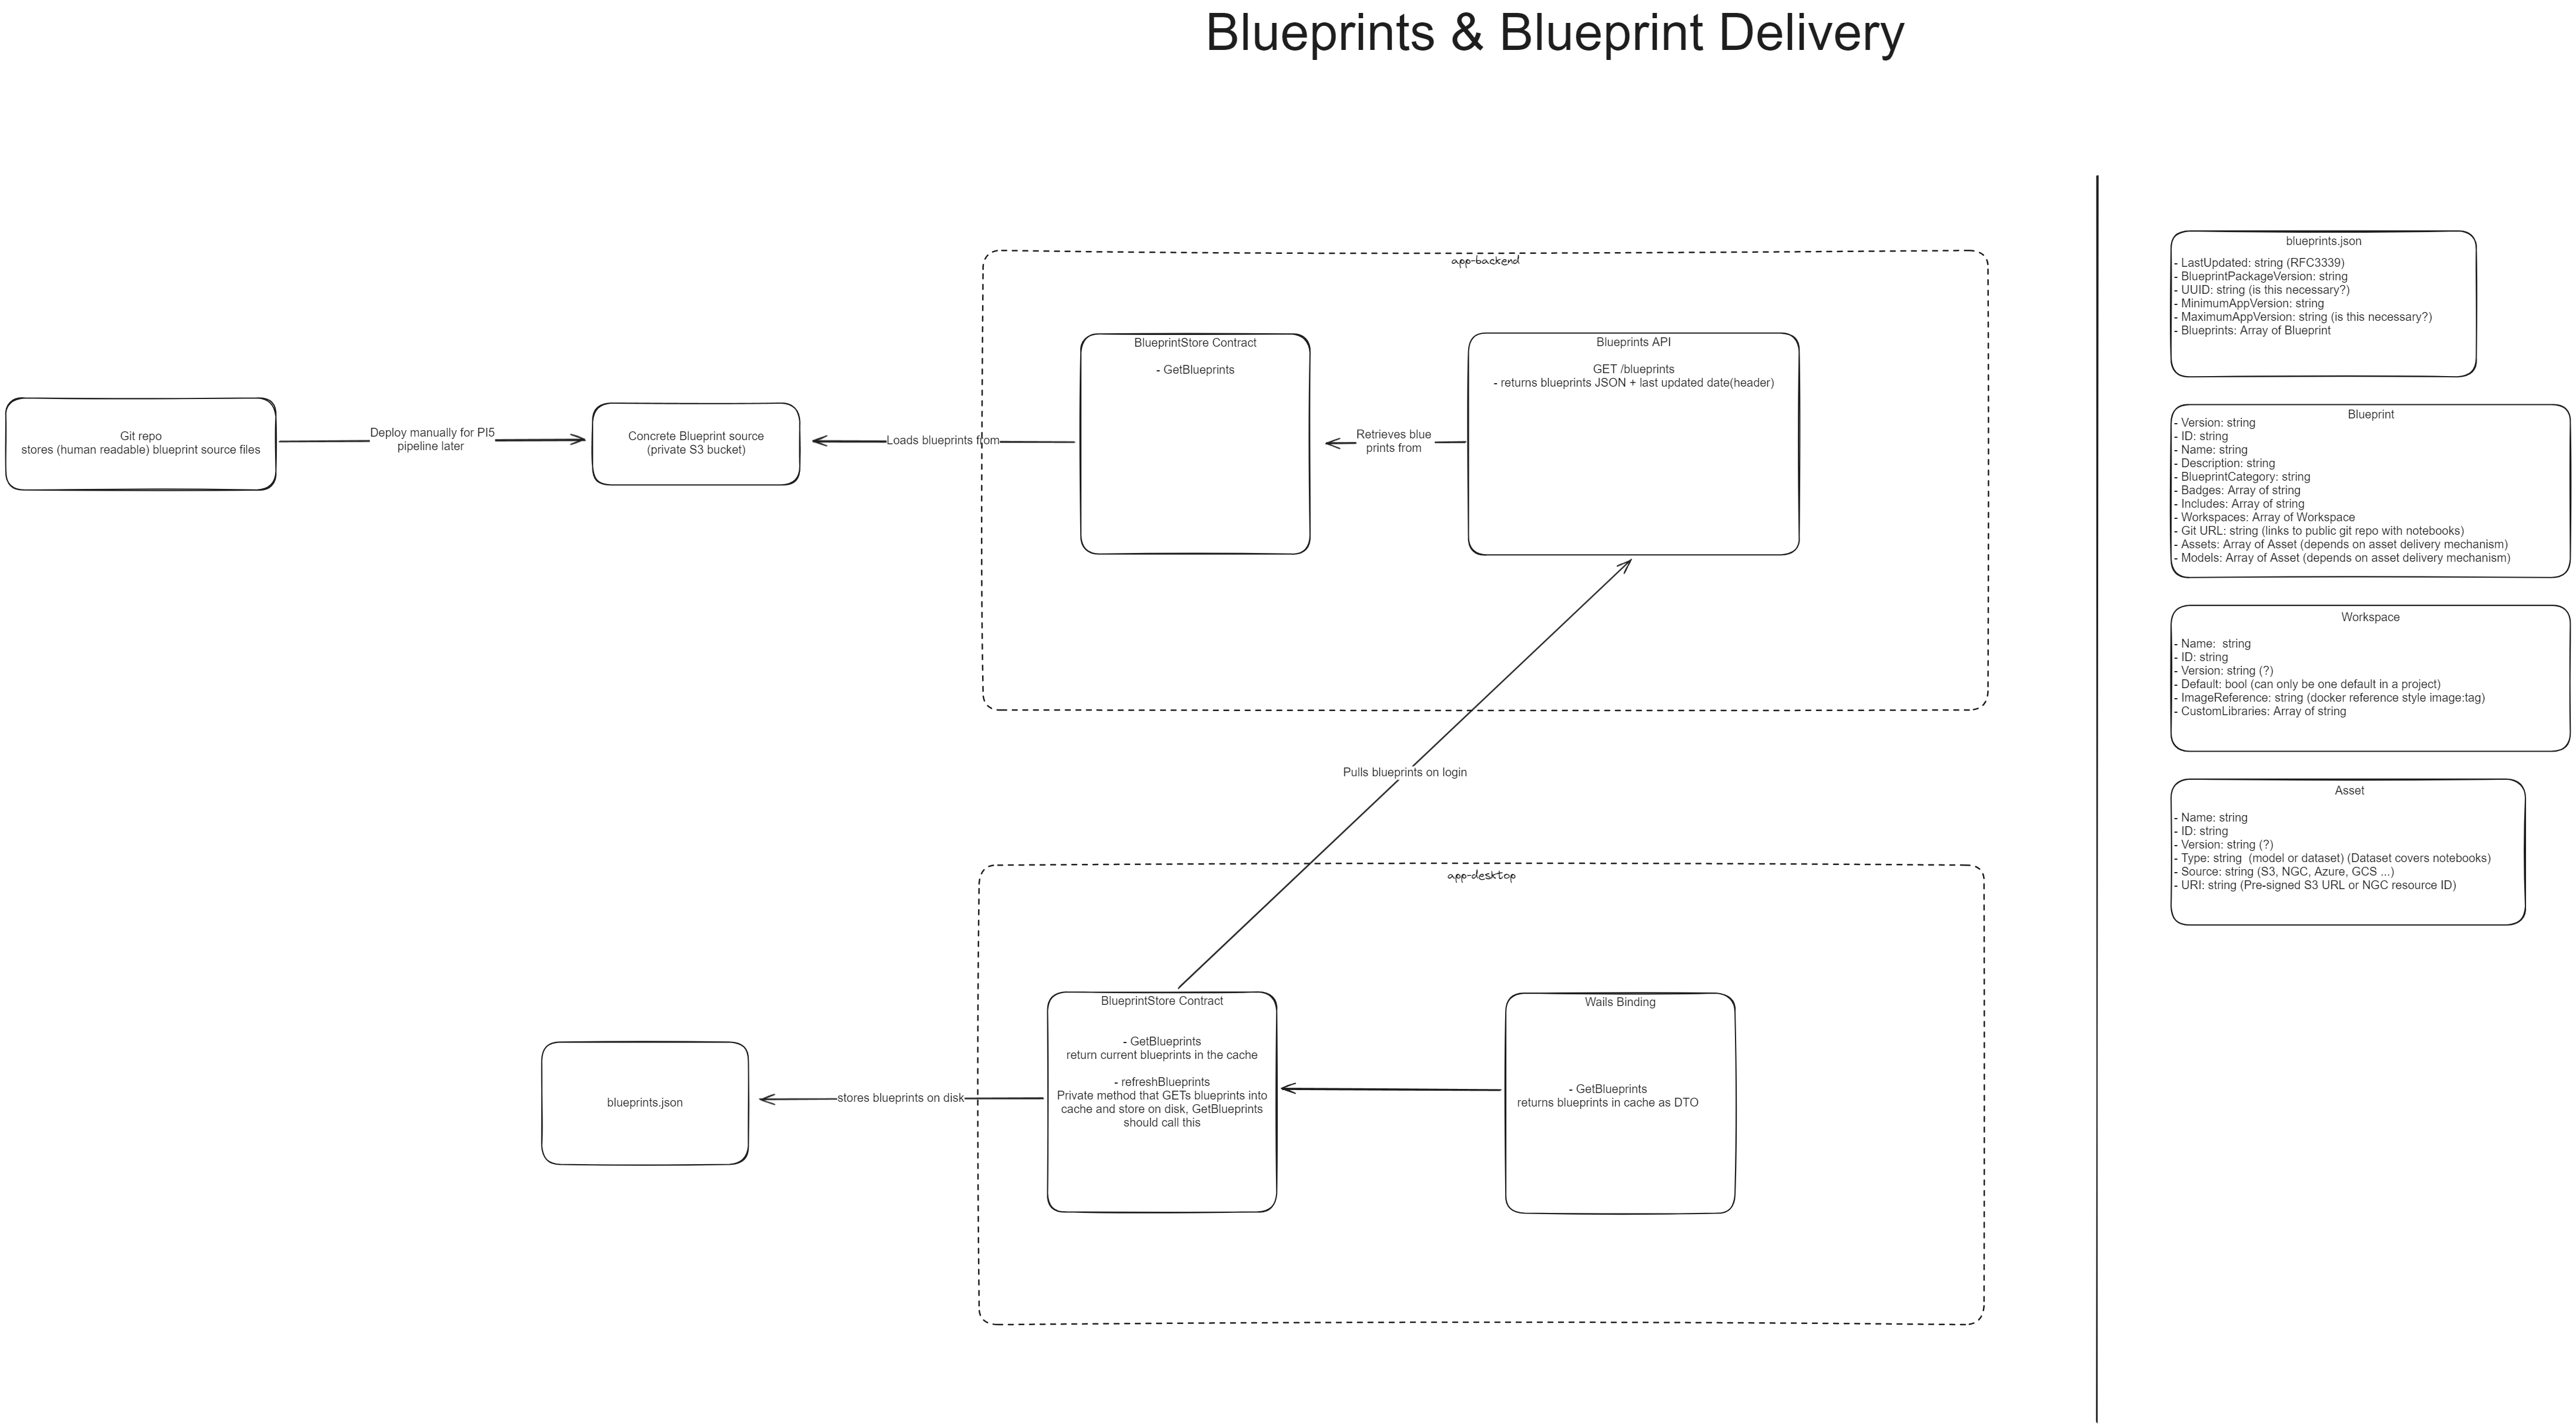

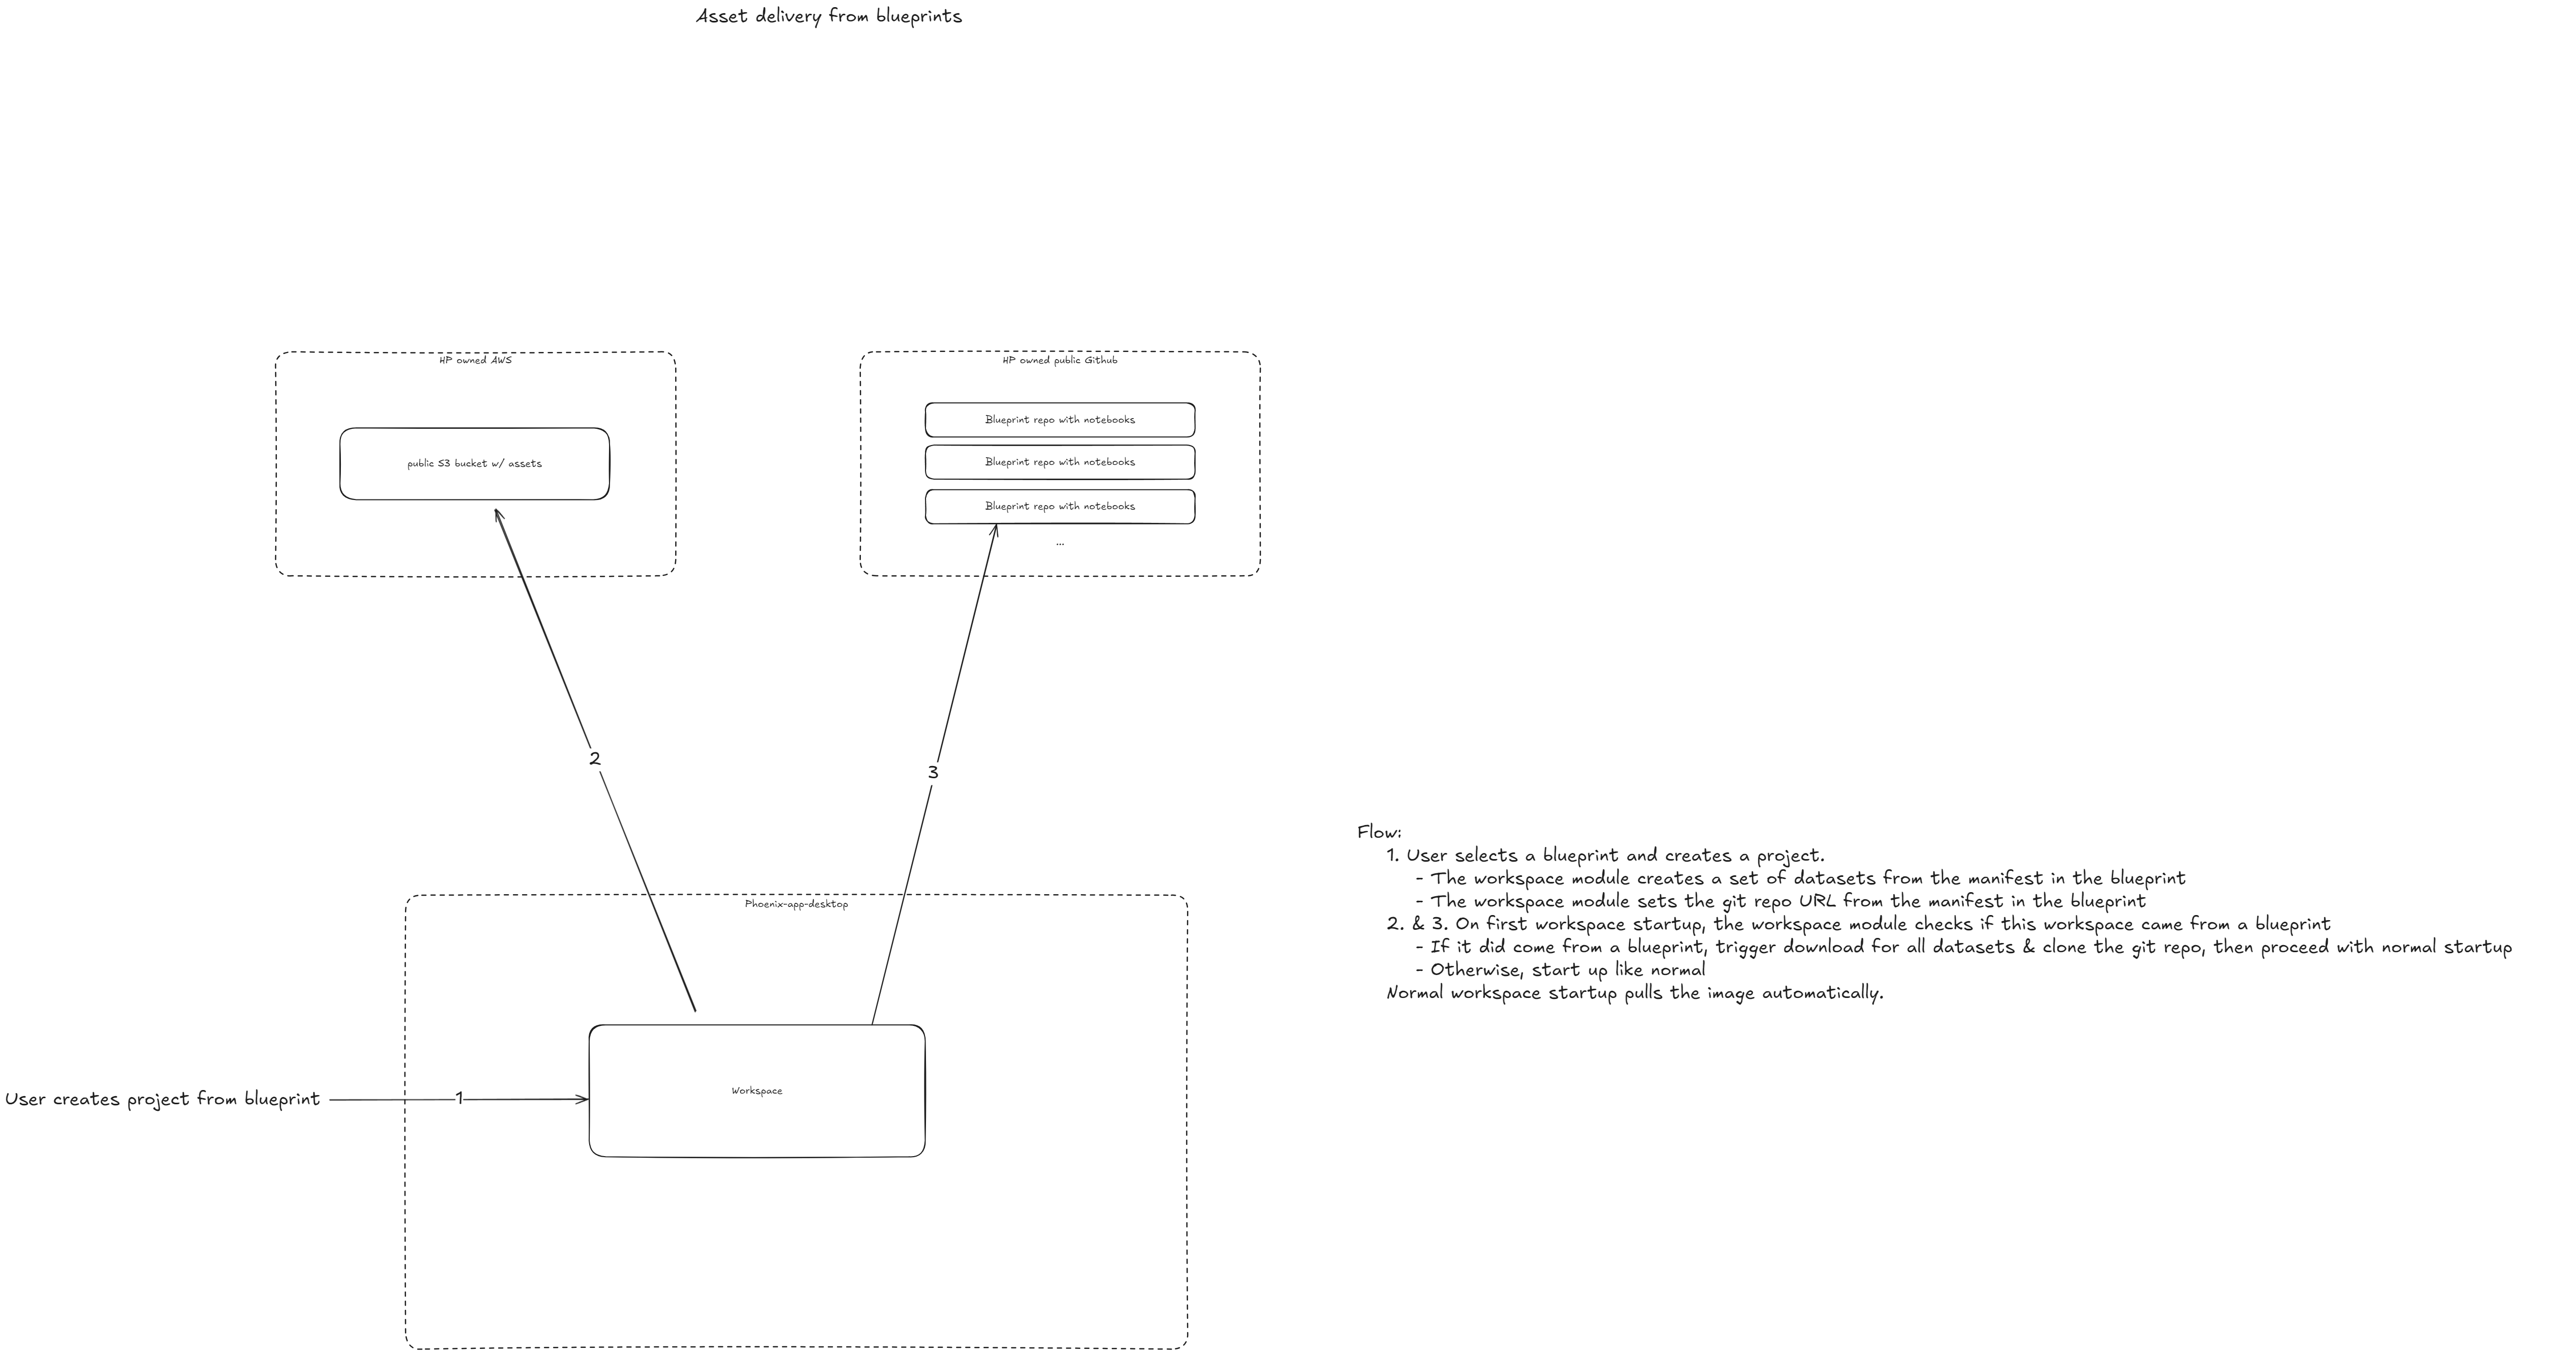

------------------------------------------------------------

2025-08-04 22:41:27 - INFO - Processing query: 'What are some feature flags that I can enable in AIStudio?'...
2025-08-04 22:41:27 - INFO - Received new query. Lock acquired. Processing new request...
2025-08-04 22:41:27 - INFO - Cloning wiki to temporary directory...
2025-08-04 22:41:27 - INFO - Starting ADO Wiki clone process...
2025-08-04 22:41:27 - INFO - Cloning wiki 'Phoenix-DS-Platform.wiki' to temporary directory: /tmp/tmpmq3y_tpt
2025-08-04 22:41:55 - INFO - Scanning for Markdown files...
2025-08-04 22:41:55 - INFO - → Found 575 Markdown pages.
2025-08-04 22:41:55 - INFO - Copying referenced images to /tmp/tmp7ung0s_0/images...
2025-08-04 22:41:56 - INFO - → 791 unique images copied.
2025-08-04 22:41:56 - INFO - Assembling flat JSON structure...
2025-08-04 22:41:56 - INFO - ✅ Wiki data successfully cloned to /tmp/tmp7ung0s_0
2025-08-04 22:41:56 - INFO - Cleaned up temporary directory: /tmp/tmpmq3y_tpt
2025-08-04 22:

In [ ]:
%%time

all_results = []

if loaded_model:
    logger.info("--- Running sample inference with the loaded model ---")
    
    try:
        # 1. Load config and secrets ONCE before making queries.
        config = load_config(CONFIG_PATH)
        ADO_PAT = os.getenv("AIS_ADO_TOKEN")
        if not ADO_PAT:
            logger.info("Environment variable not found. Falling back to secrets.yaml.")
            secrets = load_secrets(SECRETS_PATH)
            ADO_PAT = secrets.get('AIS_ADO_TOKEN')

        # 2. Construct the payload dictionary that will be sent with each request.
        request_payload_dict = {
            "config": config,
            "secrets": {"AIS_ADO_TOKEN": ADO_PAT}
        }
        
        sample_queries = [
            "What are the AI Blueprints Repository best practices?",
            "What are some feature flags that I can enable in AIStudio?",
            "How do I manually clean my environment without hooh?",
        ]

        # 3. For each query, send BOTH the query and the payload.
        for query in sample_queries:
            logger.info(f"Processing query: '{query}'...")
            
            # Create the DataFrame that matches the model's signature
            prediction_df = pd.DataFrame([{
                "query": query,
                "payload": json.dumps(request_payload_dict),
            }])
            
            result_df = loaded_model.predict(prediction_df)
            result_df['query'] = query
            display_results(query, result_df)

            all_results.append(result_df)

    except Exception as e:
        logger.error(f"Prediction failed: {e}", exc_info=True)

    # --- ADD: Combine all individual results into one DataFrame ---
    if all_results:
        final_results_df = pd.concat(all_results, ignore_index=True)
    else:
        final_results_df = pd.DataFrame()

else:
    logger.warning("Skipping sample inference because the model was not loaded.")
    # --- ADD: Ensure the variable exists ---
    final_results_df = pd.DataFrame()

## Step 5: Log Hallucinations & Relevance Evaluations to MlFlow

In [ ]:
if loaded_model and 'run_id' in locals() and not final_results_df.empty:
    logger.info(f"--- Reopening original run ({run_id}) to log pre-computed evaluations ---")

    # The results_df already contains the scores from the `predict` calls
    results_df = final_results_df
    
    # Reopen the existing run using its ID
    with mlflow.start_run(run_id=run_id) as run:
        logger.info("Successfully reopened existing run. Logging metrics and artifacts...")

        # Calculate average scores from the DataFrame
        avg_faithfulness = results_df["faithfulness"].astype(float).mean()
        avg_relevance = results_df["relevance"].astype(float).mean()
        avg_pipeline_time = results_df["total_pipeline_time_seconds"].astype(float).mean()

        # Log the average scores as metrics
        mlflow.log_metrics({
            "avg_faithfulness": avg_faithfulness,
            "avg_relevance": avg_relevance,
            "avg_pipeline_time_seconds": avg_pipeline_time,
        })

        # Log the detailed results as a table artifact
        mlflow.log_table(
            data=results_df[['query', 'reply', 'faithfulness', 'relevance', 'total_pipeline_time_seconds']], 
            artifact_file="stateless_evaluation_results.json"
        )
        
        logger.info("✅ Successfully logged metrics and artifacts to the original model run.")

else:
    logger.warning("Skipping evaluation logging because the model was not loaded, run_id was not found, or no results were generated.")

In [ ]:
end_time: float = time.time()
elapsed_time: float = end_time - start_time
elapsed_minutes: int = int(elapsed_time // 60)
elapsed_seconds: float = elapsed_time % 60

logger.info(f"⏱️ Total execution time: {elapsed_minutes}m {elapsed_seconds:.2f}s")
logger.info("✅ Notebook execution completed.")

Built with ❤️ using Z by HP AI Studio.